In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
%matplotlib inline
mpl.rc('font', size = 15)
plt.figure(figsize=(7,6))


import numpy as np
import pandas as pd

import os
import glob

<Figure size 504x432 with 0 Axes>

In [131]:
data_path = '/content/drive/MyDrive/data/competitive-data-science-predict-future-sales/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [132]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


타겟값이 월간 판매량이므로 date_block_num피처로 그룹화해서 일간을 월간으로 만들어주어야함

In [133]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


shops.shop_name의 첫번째 문자열은 러시아어로 지역을 뜻하므로 따로 피처를 만들어주어야함

In [134]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [135]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [136]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [137]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [138]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [139]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


id를 키로 데이터 병합

In [140]:
train = sales_train.merge(shops, on='shop_id', how='left')
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


In [141]:
def resumetable(df):
    print(f'데이터셋 형상 : {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터타입']) #.sort_values()
    summary = summary.reset_index()
    summary = summary.rename(columns = {'index':'피처'})

    #summary['결측치 개수'] = df.isnull().sum().values #결측치가 존재하지 않더라도 -1같은 값으로 있는 경우가 있으니 확인 필요!
    
    summary['결측치 개수'] = (df == -1).sum().values # 피처별 -1 개수

    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    # summary['세 번째 값'] = df.loc[2].values

    # for col in df.columns: 
        
    #     if 'bin' in col or col == 'target':
    #         summary.loc[col, '데이터 종류'] = '이진형'
    #     elif 'cat' in col:
    #         summary.loc[col, '데이터 종류'] = '명목형'
    #     elif df[col].dtype == float:
    #         summary.loc[col, '데이터 종류'] = '연속형'
    #     elif df[col].dtype == int:
    #         summary.loc[col, '데이터 종류'] = '순서형'

    return summary

In [142]:
summary = resumetable(train)
summary

데이터셋 형상 : (2935849, 10)


,피처,데이터타입,결측치 개수,고윳값 개수,첫 번째 값,두 번째 값
0,date,object,0,1034,02.01.2013,03.01.2013
1,date_block_num,int64,0,34,0,0
2,shop_id,int64,0,60,59,25
3,item_id,int64,0,21807,22154,2552
4,item_price,float64,1,19993,999.0,899.0
5,item_cnt_day,float64,7252,198,1.0,1.0
6,shop_name,object,0,60,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум"""
7,item_name,object,0,21807,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP
8,item_category_id,int64,0,84,37,58
9,item_category_name,object,0,84,Кино - Blu-Ray,Музыка - Винил


#시각화

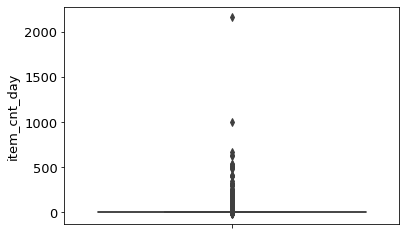

In [143]:
sns.boxplot(y='item_cnt_day',data=train)

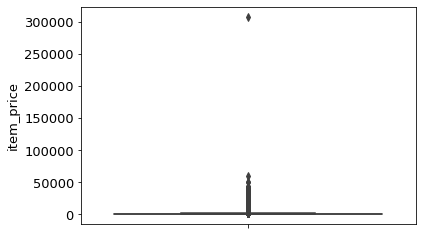

In [144]:
sns.boxplot(y='item_price', data=train)

이상치 때문에 123분위수가 납작해지는 상황이 발생 이상치를 제거 후 다시 시각화 필요

일별 판매량을 groupby를 통해서 월별로 바꿔줌


In [145]:
#train.groupby('date_block_num')['item_cnt_day'].sum().reset_index()

#위에가 평소에 내가 쓰던 코드인데 아래 코드가 더 범용성이 좋아 되도록이면 .agg를 사용해서 groupby를 해야겠다.
group = train.groupby('date_block_num').agg({'item_cnt_day' : 'sum'}).reset_index()
group

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0
5,5,125381.0
6,6,116966.0
7,7,125291.0
8,8,133332.0
9,9,127541.0


월별판매량

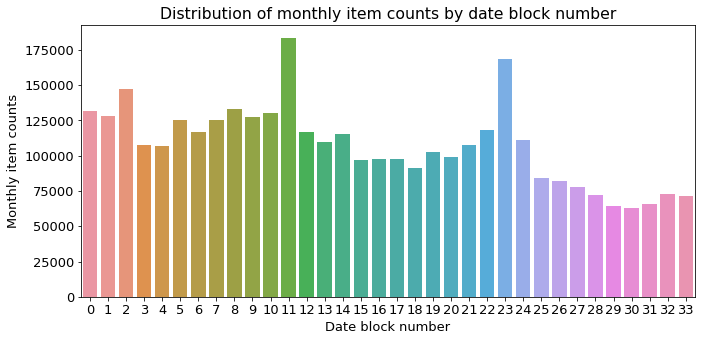

In [146]:
mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# 월별 총 상품 판매량
group_month_sum = train.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group_month_sum = group_month_sum.reset_index()

# 월별 총 상품 판매량 막대그래프
sns.barplot(x='date_block_num', y='item_cnt_day', data=group_month_sum)
# 그래프 제목, x축 라벨, y축 라벨명 설정
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

상품분류별판매량

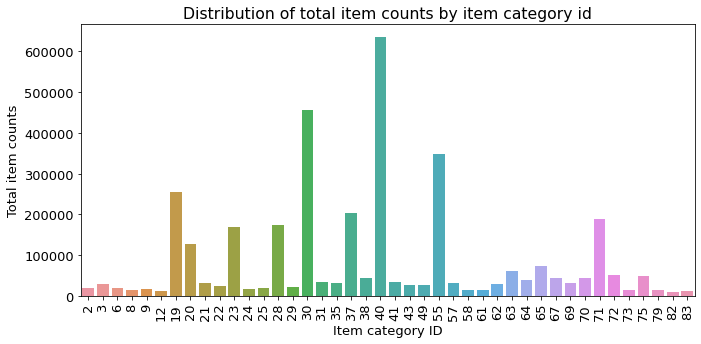

In [147]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# 상품분류별 총 상품 판매량
group_cat_sum = train.groupby('item_category_id').agg({'item_cnt_day': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# 총 판매량이 10,000개를 초과하는 상품분류만 추출
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_day'] > 10000]

# 상품분류별 총 상품 판매량 막대그래프
sns.barplot(x='item_category_id', y='item_cnt_day', data=group_cat_sum)
ax.set(title='Distribution of total item counts by item category id',
       xlabel='Item category ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90) # x축 라벨 회전

상점별판매량

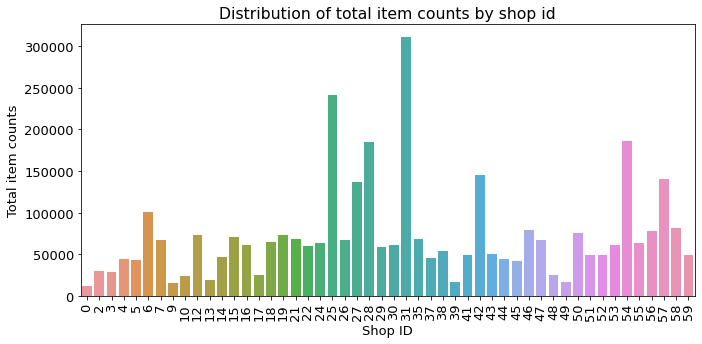

In [148]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# 상점별 총 상품 판매량
group_shop_sum = train.groupby('shop_id').agg({'item_cnt_day': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_day'] > 10000]

# 상점별 총 상품 판매량 막대그래프
sns.barplot(x='shop_id', y='item_cnt_day', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

#최종 데이터 생성

In [149]:
import warnings
warnings.filterwarnings(action='ignore')

#피처 한글화
sales_train = sales_train.rename(columns={'date': '날짜', 
                                          'date_block_num': '월ID',
                                          'shop_id': '상점ID',
                                          'item_id': '상품ID',
                                          'item_price': '판매가',
                                          'item_cnt_day': '판매량'})

shops = shops.rename(columns={'shop_name': '상점명',
                              'shop_id': '상점ID'})

items = items.rename(columns={'item_name': '상품명',
                              'item_id': '상품ID',
                              'item_category_id': '상품분류ID'})

item_categories = item_categories.rename(columns=
                                         {'item_category_name': '상품분류명',
                                          'item_category_id': '상품분류ID'})

test = test.rename(columns={'shop_id': '상점ID',
                            'item_id': '상품ID'})

##다운캐스팅


In [150]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [151]:
#다운캐스팅을 통해서 데이터의 메모리를 줄이고 학습속도를 향상시키자
all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

62.5% 압축됨
38.6% 압축됨
54.2% 압축됨
39.9% 압축됨
70.8% 압축됨


우리가 예측해야 하는 값은 각 상점의 상품별 월간 판매량<br>
따라서 월 상점 상품별 조합이 필요하다

In [152]:
from itertools import product
[i for i in product('abc','def',range(2))]

[('a', 'd', 0),
 ('a', 'd', 1),
 ('a', 'e', 0),
 ('a', 'e', 1),
 ('a', 'f', 0),
 ('a', 'f', 1),
 ('b', 'd', 0),
 ('b', 'd', 1),
 ('b', 'e', 0),
 ('b', 'e', 1),
 ('b', 'f', 0),
 ('b', 'f', 1),
 ('c', 'd', 0),
 ('c', 'd', 1),
 ('c', 'e', 0),
 ('c', 'e', 1),
 ('c', 'f', 0),
 ('c', 'f', 1)]

sales_train에 그 월에 판매량이 없으면 데이터가 존재하지 않는다 유의미한 데이터는 많을수로 좋으므로 product함수를 통해서 판매량이 없는 날의 데이터도 만들자!

In [153]:
train =[]
for i in sales_train['월ID'].unique():
    all_shop = sales_train.loc[sales_train['월ID']==i, '상점ID'].unique()
    all_item = sales_train.loc[sales_train['월ID']==i, '상품ID'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['월ID', '상점ID', '상품ID']

train = pd.DataFrame(np.vstack(train), columns=idx_features)
train

,월ID,상점ID,상품ID
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10913845,33,21,7635
10913846,33,21,7638
10913847,33,21,7640
10913848,33,21,7632


In [154]:
group = sales_train.groupby(idx_features).agg({'판매량':'sum'})
group = group.reset_index()
group = group.rename(columns = {'판매량':'월간 판매량'})
group

,월ID,상점ID,상품ID,월간 판매량
0,0,0,32,6
1,0,0,33,3
2,0,0,35,1
3,0,0,43,1
4,0,0,51,2
...,...,...,...,...
1609119,33,59,22087,6
1609120,33,59,22088,2
1609121,33,59,22091,1
1609122,33,59,22100,1


In [155]:
train = train.merge(group, on=idx_features, how='left')
train

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN
...,...,...,...,...
10913845,33,21,7635,NaN
10913846,33,21,7638,NaN
10913847,33,21,7640,NaN
10913848,33,21,7632,NaN


##가비지 컬렉션

메모리를 줄이기위해 group같은 이미 사용하고 필요없는 피처는 이 기능을 통해서 메모리 관리를 해주자

In [156]:
import gc

del group
gc.collect()

88

In [157]:
test['월ID'] = 34
try:
    test = test.drop('ID',axis=1)
except:
    None

In [158]:
idx_features

['월ID', '상점ID', '상품ID']

In [159]:
all_data = pd.concat([train,test], ignore_index=True, keys=idx_features)
all_data

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN
...,...,...,...,...
11128045,34,45,18454,NaN
11128046,34,45,16188,NaN
11128047,34,45,15757,NaN
11128048,34,45,19648,NaN


In [160]:
all_data = all_data.fillna(0)

shops, items, item_categories 데이터들을 각각의 ID를 기준으로 merge를 해줘서 새로운 피처를 만들어주자!

In [161]:
all_data = all_data.merge(shops, on='상점ID', how='left')
all_data = all_data.merge(items, on='상품ID', how='left')
all_data = all_data.merge(item_categories, on='상품분류ID', how='left')

all_data = downcast(all_data)

del shops, items, item_categories
gc.collect()

26.4% 압축됨


44

In [162]:
all_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 8 columns):
 #   Column  Non-Null Count     Dtype 
---  ------  --------------     ----- 
 0   월ID     11128050 non-null  int8  
 1   상점ID    11128050 non-null  int8  
 2   상품ID    11128050 non-null  int16 
 3   월간 판매량  11128050 non-null  int16 
 4   상점명     11128050 non-null  object
 5   상품명     11128050 non-null  object
 6   상품분류ID  11128050 non-null  int8  
 7   상품분류명   11128050 non-null  object
dtypes: int16(2), int8(3), object(3)
memory usage: 413.9+ MB


상점명과 상점ID 등등은 1대1대응이므로 하나만 있으면 된다. 이름은 러시아러라 사용하기 힘드므로 drop해주자

In [163]:
all_data.drop(['상점명','상품명','상품분류명'],axis=1,inplace=True)

In [164]:
all_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 5 columns):
 #   Column  Non-Null Count     Dtype
---  ------  --------------     -----
 0   월ID     11128050 non-null  int8 
 1   상점ID    11128050 non-null  int8 
 2   상품ID    11128050 non-null  int16
 3   월간 판매량  11128050 non-null  int16
 4   상품분류ID  11128050 non-null  int8 
dtypes: int16(2), int8(3)
memory usage: 159.2 MB


In [165]:
# 훈련 데이터 (피처)
X_train = all_data[all_data['월ID'] < 33]
X_train = X_train.drop(['월간 판매량'], axis=1)
# 검증 데이터 (피처)
X_valid = all_data[all_data['월ID'] == 33]
X_valid = X_valid.drop(['월간 판매량'], axis=1)
# 테스트 데이터 (피처)
X_test = all_data[all_data['월ID'] == 34]
X_test = X_test.drop(['월간 판매량'], axis=1)

# 훈련 데이터 (타깃값)
y_train = all_data[all_data['월ID'] < 33]['월간 판매량']
y_train = y_train.clip(0, 20) # 타깃값을 0 ~ 20로 제한
# 검증 데이터 (타깃값)
y_valid = all_data[all_data['월ID'] == 33]['월간 판매량']
y_valid = y_valid.clip(0, 20)

In [166]:
del all_data
gc.collect()

22

#모델 훈련 및 성능 검증

In [167]:
import lightgbm as lgb

# LightGBM 하이퍼파라미터
params = {'metric': 'rmse', # 평가지표 = rmse
          'num_leaves': 255,
          'learning_rate': 0.01,
          'force_col_wise': True,
          'random_state': 10}

# 범주형 피처 설정
cat_features = ['상점ID', '상품분류ID']

# LightGBM 훈련 및 검증 데이터셋
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)

# LightGBM 모델 훈련
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=500,
                      valid_sets=(dtrain, dvalid),
                      categorical_feature=cat_features,
                      verbose_eval=50)  

[50]	training's rmse: 1.14825	valid_1's rmse: 1.06792
[100]	training's rmse: 1.11462	valid_1's rmse: 1.03703
[150]	training's rmse: 1.09695	valid_1's rmse: 1.02457
[200]	training's rmse: 1.08566	valid_1's rmse: 1.01793
[250]	training's rmse: 1.07749	valid_1's rmse: 1.01381
[300]	training's rmse: 1.07062	valid_1's rmse: 1.01046
[350]	training's rmse: 1.06458	valid_1's rmse: 1.00774
[400]	training's rmse: 1.05865	valid_1's rmse: 1.00578
[450]	training's rmse: 1.05332	valid_1's rmse: 1.00426
[500]	training's rmse: 1.04903	valid_1's rmse: 1.00287


In [168]:
preds = lgb_model.predict(X_test).clip(0,20)

In [169]:
submission['item_cnt_month'] = preds
submission.to_csv('submission.csv',index=False)